https://www.kaggle.com/c/ultrasound-nerve-segmentation/data

Este ejercicio consiste en segmentar un conjunto de nervios llamados Plexo Braquial (BP) en imágenes de ultrasonido. Se proporciona un gran conjunto de imágenes de entrenamiento donde el nervio ha sido anotado manualmente por humanos. Los anotadores fueron capacitados por expertos e instruidos para anotar imágenes en las que se sentían seguros acerca de la existencia del punto de referencia de BP.

Puntos importantes:

El conjunto de datos contiene imágenes donde el BP no está presente. el algoritmo no debe predecir valores de píxeles en estos casos.
Al igual que con todos los datos etiquetados por humanos, cabe esperar encontrar ruido, artefactos y posibles errores en las máscaras etiquetadas.

In [1]:
!pip install --upgrade --no-cache-dir gdown
## Para evitar un error de permiso

!gdown --id 10NPOJVzi7NP14mszsJnjn0uUtUpTP0zo


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=10NPOJVzi7NP14mszsJnjn0uUtUpTP0zo
From (redirected): https://drive.google.com/uc?id=10NPOJVzi7NP14mszsJnjn0uUtUpTP0zo&confirm=t&uuid=81cef4a4-c21f-4a72-ac0b-6a498b6fefde
To: /content/ultrasound-nerve-segmentation.zip
100% 2.27G/2.27G [00:15<00:00, 142MB/s]


In [2]:
!unzip ultrasound-nerve-segmentation.zip > /dev/null

In [3]:
!pip install imagecodecs
# Reset runtime after install

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 13.3 MB/s eta 0:00:00


In [4]:
# for reading and processing images
import imageio
from PIL import Image
import tifffile
# import imagecodecs
import cv2

import os
import random

# for visualizations
import matplotlib.pyplot as plt

import tensorflow.keras as keras
import numpy as np # for using np arrays
from numpy import asarray

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

# Carga de datos

In [5]:
def LoadData (path):
    # Read the images folder like a list
    image_dataset = os.listdir(path)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    image_dataset.sort()
    for file in image_dataset:
        if file.endswith('_mask.tif'):
            mask_img.append(file)
            orig_img.append(file.replace("_mask.tif",".tif"))

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    # orig_img.sort()
    # mask_img.sort()

    return orig_img, mask_img

(420, 580)
(420, 580)


<ipython-input-6-d63b097b22eb>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path + img[show_images])
<ipython-input-6-d63b097b22eb>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path + mask[show_images])


Text(0.5, 1.0, 'Masked Image 11_113_mask.tif')

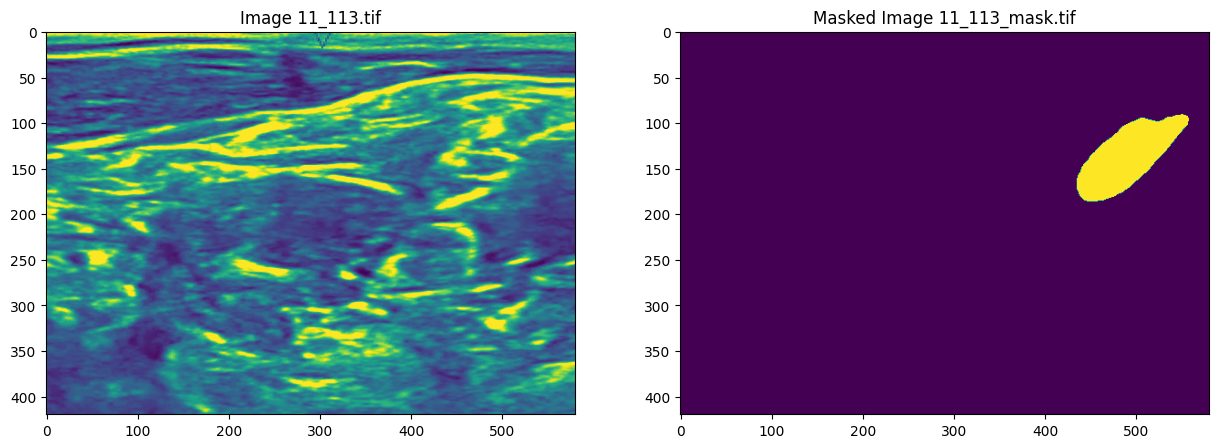

In [6]:
path = 'train/'
img, mask = LoadData(path)

show_images = 134

img_view  = imageio.imread(path + img[show_images])
mask_view = imageio.imread(path + mask[show_images])

print(img_view.shape)
print(mask_view.shape)
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(img_view)
arr[0].set_title('Image ' + img[show_images])
arr[1].imshow(mask_view)
arr[1].set_title('Masked Image '+ mask[show_images])

In [7]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path1 = os.path.join(path, file)
        single_img = Image.open(path1).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c))
        single_img = single_img/256.
        X[index] = single_img

        # convert mask into an array of desired shape (1 channel)

        single_mask_ind = mask[index]
        path1 = os.path.join(path, single_mask_ind)
        single_mask = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
        single_mask = cv2.resize(single_mask, dsize=(m_h, m_w), interpolation=cv2.INTER_NEAREST)
        single_mask = asarray(single_mask)
        single_mask = single_mask[..., tf.newaxis]
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c))
        single_mask = single_mask/255
        single_mask = single_mask.astype(int)
        y[index] = single_mask
    return X, y

X Shape: (5635, 128, 128, 3)
y shape: (5635, 128, 128, 1)
[0 1]


Text(0.5, 1.0, 'Processed Masked Image ')

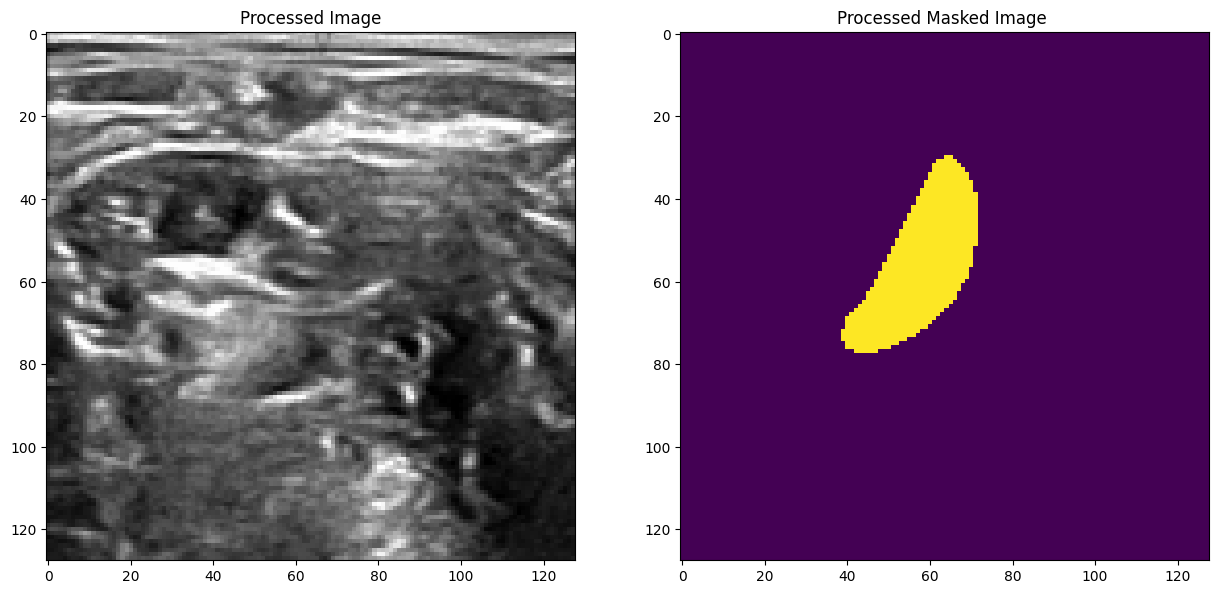

In [13]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function

X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path)

# QC the shape of output and classes in output dataset
print("X Shape:", X.shape)
print("y shape:", y.shape)
# There are 2 classes
print(np.unique(y))

# Visualize the output
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

# Modelo U-Net

**PREGUNTA**

1. Crea un modelo U-Net

In [9]:
## Seeding
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [10]:
IMG_HEIGHT = 128
IMG_WIDTH  = 128
CHANNELS = 3

In [11]:
import tensorflow as tf
from tensorflow import keras

def down_block(inputs, filters, pool=True):
    conv = keras.layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(inputs)
    conv = keras.layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(conv)
    pool = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

def up_block(inputs, skip, filters):
    up_sample = keras.layers.UpSampling2D((2, 2))(inputs)
    concat = keras.layers.Concatenate()([up_sample, skip])
    conv = keras.layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(concat)
    conv = keras.layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(conv)
    return conv

def bottleneck(inputs, filters):
    conv = keras.layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(inputs)
    conv = keras.layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(conv)
    return conv


def UNet():
    inputs = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, CHANNELS))

    c1, p1 = down_block(inputs, 16, pool=True)
    c2, p2 = down_block(p1, 32, pool=True)
    c3, p3 = down_block(p2, 64, pool=True)
    c4, p4 = down_block(p3, 128, pool=True)


    bn = bottleneck(p4, 256)


    u1 = up_block(bn, c4, 128)
    u2 = up_block(u1, c3, 64)
    u3 = up_block(u2, c2, 32)
    u4 = up_block(u3, c1, 16)


    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

model_unet = UNet()
model_unet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model_unet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

**PREGUNTA**

2. Muestra una imagen junto a su máscara

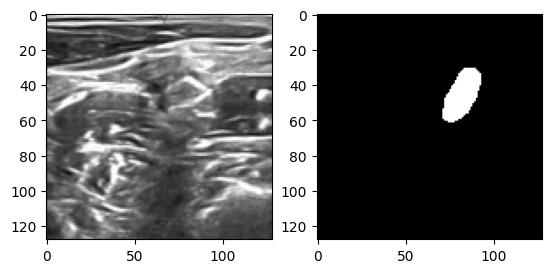

In [14]:
# Imagen y su máscara
i = np.random.randint(0,len(X))
fig,(a1,a2)=plt.subplots(1,2)
a1.imshow(X[i])
a2.imshow(y[i].reshape(y[i].shape[:-1]), cmap='gray')

**PREGUNTA**
3. Crea un conjunto de imágenes de test, junto con sus máscaras, con un 10% de las imágenes y máscaras de entrenamiento

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.1, random_state=42)

**PREGUNTA**

4. Entrena la U-net con early stopping maximizando el accuracy de validación (5 de paciencia). Entrena durante 25 épocas como máximo y vlidation_split del 10%
5. Calcula el accuracy del modelo con los datos de test.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [17]:
results = model_unet.fit(X_train,y_train, epochs=25, validation_split=0.1, callbacks=[es])
model_unet.save('models/human_segmentation_non-aug_100_v2.h5')

Epoch 1/25
143/143 [==============================] - 34s 118ms/step - loss: 0.0682 - accuracy: 0.9874 - val_loss: 0.0411 - val_accuracy: 0.9885
Epoch 2/25
143/143 [==============================] - 10s 73ms/step - loss: 0.0373 - accuracy: 0.9878 - val_loss: 0.0324 - val_accuracy: 0.9885
Epoch 3/25
143/143 [==============================] - 11s 76ms/step - loss: 0.0292 - accuracy: 0.9878 - val_loss: 0.0268 - val_accuracy: 0.9885
Epoch 4/25
143/143 [==============================] - 11s 74ms/step - loss: 0.0276 - accuracy: 0.9878 - val_loss: 0.0251 - val_accuracy: 0.9888
Epoch 5/25
143/143 [==============================] - 11s 76ms/step - loss: 0.0252 - accuracy: 0.9900 - val_loss: 0.0242 - val_accuracy: 0.9908
Epoch 6/25
143/143 [==============================] - 11s 75ms/step - loss: 0.0238 - accuracy: 0.9908 - val_loss: 0.0233 - val_accuracy: 0.9915
Epoch 7/25
143/143 [==============================] - 11s 76ms/step - loss: 0.0227 - accuracy: 0.9911 - val_loss: 0.0256 - val_accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
y_pred = model_unet.predict(X_test)
accuracy = model_unet.evaluate(X_test, y_test)[1]
print(f"Accuracy del modelo en los datos de test: {accuracy}")

18/18 [==============================] - 0s 20ms/step - loss: 0.0222 - accuracy: 0.9916
Accuracy del modelo en los datos de test: 0.991588294506073


**PREGUNTA**

6. Realiza predicciones con los datos de test y muestra una imagen y máscara aleatoramiente de entre los datos de test.

In [19]:
model = keras.models.load_model('models/human_segmentation_non-aug_100_v2.h5')

In [20]:
predictions = model.predict(X_test)


18/18 [==============================] - 1s 20ms/step


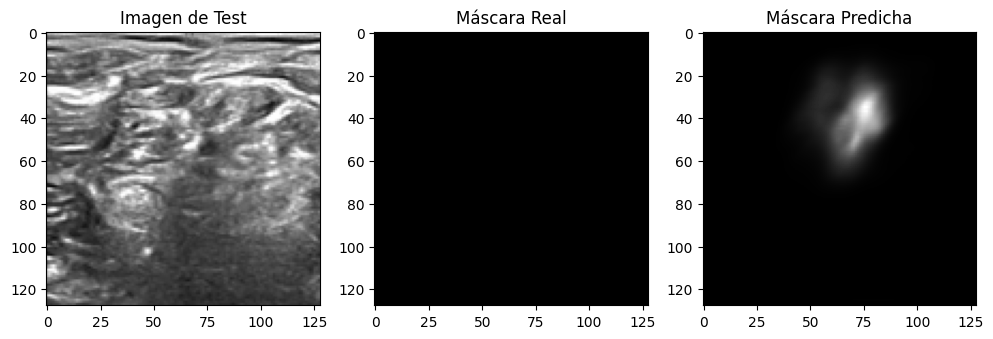

In [22]:
idx = np.random.randint(0, len(X_test))
image = X_test[idx]
mask = y_test[idx]
predicted_mask = predictions[idx]  # Máscara predicha por el modelo

# Imagen original
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Imagen de Test')

# Mascara real
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Máscara Real')

# Máscara predicha
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Máscara Predicha')

plt.show()


# Otras métricas

**PREGUNTA**

7. Prueba con las métricas (IoU y Dice) (en el Early Stopping también). Aprende cómo calcularlos aquí:

https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

https://medium.com/@nghihuynh_37300/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f#:~:text=Dice%20coefficient%20%3D%20F1%20score%3A%20a,recall%2C%20or%20vice%2Dversa.


Sólo empieza a entrenar los modelos. No es necesario que termines. El tiempo de ejecución es bastante mayor

Aquí tenéis el código para calcular las métricas.

In [23]:
IMG_HEIGHT = 128
IMG_WIDTH  = 128
CHANNELS = 3

In [24]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [25]:
model_unet = UNet()
model_unet.compile(optimizer="adam", loss="binary_crossentropy", metrics=[ dice_coef])
#model_unet.summary()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
early_stopping = EarlyStopping(monitor='dice_coef' , patience=10, verbose=1)



In [26]:
history = model_unet.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=16,
                    callbacks=[early_stopping])

Epoch 1/100
282/282 [==============================] - 29s 63ms/step - loss: 0.0789 - dice_coef: 0.0462 - val_loss: 0.0426 - val_dice_coef: 0.0560
Epoch 2/100
282/282 [==============================] - 12s 43ms/step - loss: 0.0387 - dice_coef: 0.0947 - val_loss: 0.0300 - val_dice_coef: 0.1419
Epoch 3/100
282/282 [==============================] - 11s 40ms/step - loss: 0.0290 - dice_coef: 0.1809 - val_loss: 0.0263 - val_dice_coef: 0.1762
Epoch 4/100
282/282 [==============================] - 12s 43ms/step - loss: 0.0259 - dice_coef: 0.2099 - val_loss: 0.0261 - val_dice_coef: 0.2361
Epoch 5/100
282/282 [==============================] - 12s 42ms/step - loss: 0.0243 - dice_coef: 0.2288 - val_loss: 0.0244 - val_dice_coef: 0.2234
Epoch 6/100
282/282 [==============================] - 12s 43ms/step - loss: 0.0231 - dice_coef: 0.2400 - val_loss: 0.0263 - val_dice_coef: 0.2977
Epoch 7/100
282/282 [==============================] - 12s 44ms/step - loss: 0.0222 - dice_coef: 0.2524 - val_loss: 0.

In [27]:
model_unet1 = UNet()
model_unet1.compile(optimizer="adam", loss="binary_crossentropy", metrics=[iou_coef])
#model_unet1.summary()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
early_stopping = EarlyStopping(monitor='iou_coef' , patience=10, verbose=1)

In [28]:
history1 = model_unet1.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=16,
                    callbacks=[early_stopping])

Epoch 1/100
317/317 [==============================] - 24s 56ms/step - loss: 0.0710 - iou_coef: 0.0317 - val_loss: 0.0436 - val_iou_coef: 0.0369
Epoch 2/100
317/317 [==============================] - 13s 42ms/step - loss: 0.0393 - iou_coef: 0.0546 - val_loss: 0.0318 - val_iou_coef: 0.0673
Epoch 3/100
317/317 [==============================] - 13s 42ms/step - loss: 0.0300 - iou_coef: 0.1081 - val_loss: 0.0268 - val_iou_coef: 0.1441
Epoch 4/100
317/317 [==============================] - 13s 41ms/step - loss: 0.0266 - iou_coef: 0.1383 - val_loss: 0.0238 - val_iou_coef: 0.1552
Epoch 5/100
317/317 [==============================] - 13s 41ms/step - loss: 0.0247 - iou_coef: 0.1618 - val_loss: 0.0238 - val_iou_coef: 0.1506
Epoch 6/100
317/317 [==============================] - 13s 41ms/step - loss: 0.0231 - iou_coef: 0.1770 - val_loss: 0.0227 - val_iou_coef: 0.1454
Epoch 7/100
317/317 [==============================] - 13s 41ms/step - loss: 0.0221 - iou_coef: 0.1861 - val_loss: 0.0220 - val_io